# Segmentação de clientes em uma empresa a partir de uma análise RFM e utilizando K-Means Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Perfil dos dados, variáveis e tipos

In [2]:
df = pd.read_csv('BancoDeDados.csv')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amostra               116581 non-null  int64  
 1   id_cliente            116581 non-null  object 
 2   id_unico_cliente      116581 non-null  object 
 3   item_id               116581 non-null  int64  
 4   cep_cliente           116581 non-null  int64  
 5   cidade_cliente        116581 non-null  object 
 6   estado_cliente        116581 non-null  object 
 7   id_pedido             116581 non-null  object 
 8   status_pedido         116581 non-null  object 
 9   horario_pedido        116581 non-null  object 
 10  pedido_aprovado       116567 non-null  object 
 11  pedido_entregador     115368 non-null  object 
 12  pedido_entregue       114066 non-null  object 
 13  data_estimada         116581 non-null  object 
 14  id_vendedor           116581 non-null  object 
 15  

In [3]:
df.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,...,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


# Construindo uma função para fazer uma visualização mais intuitiva das variáveis. 

In [4]:
def plot_perc(st,dados):
    plt.figure(figsize=(20,8))
    
    g = sns.countplot(x= st,data=dados,orient='h')
    g.set_ylabel('Contagem',fontsize=17)
    
    sizes = []
    
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x() + p.get_width()/1.6,
              height+200,
              '{:1.2f}%'.format(height/116581*100),
              ha = 'center',va='bottom',fontsize=12)
        
    g.set_ylim(0,max(sizes)*1.1)

## UFs dos clientes

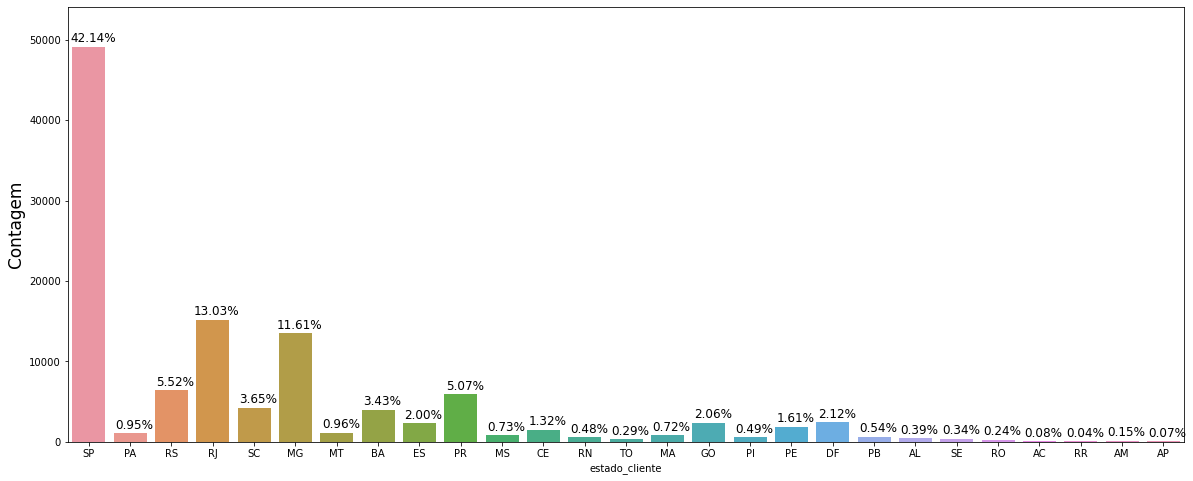

In [5]:
plot_perc('estado_cliente', df)
# maioria de clientes em SP, seguido de RJ, MG e RS...

## UFs dos vendedores

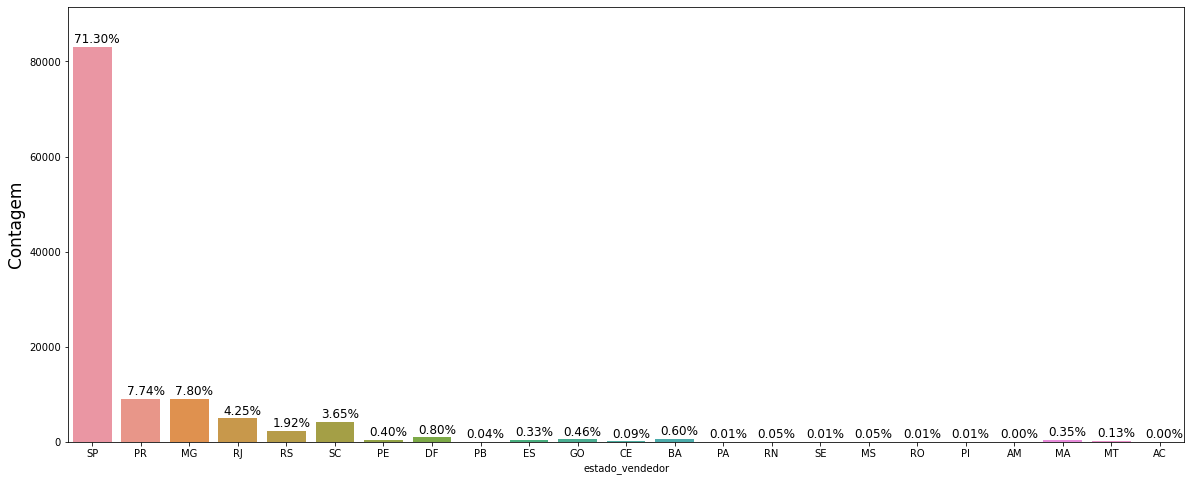

In [6]:
plot_perc ('estado_vendedor',df)
# maioria de vendedores em SP? 
# insight: poderíamos incentivar vendedores de outros estados.

## Tipos de pagamento

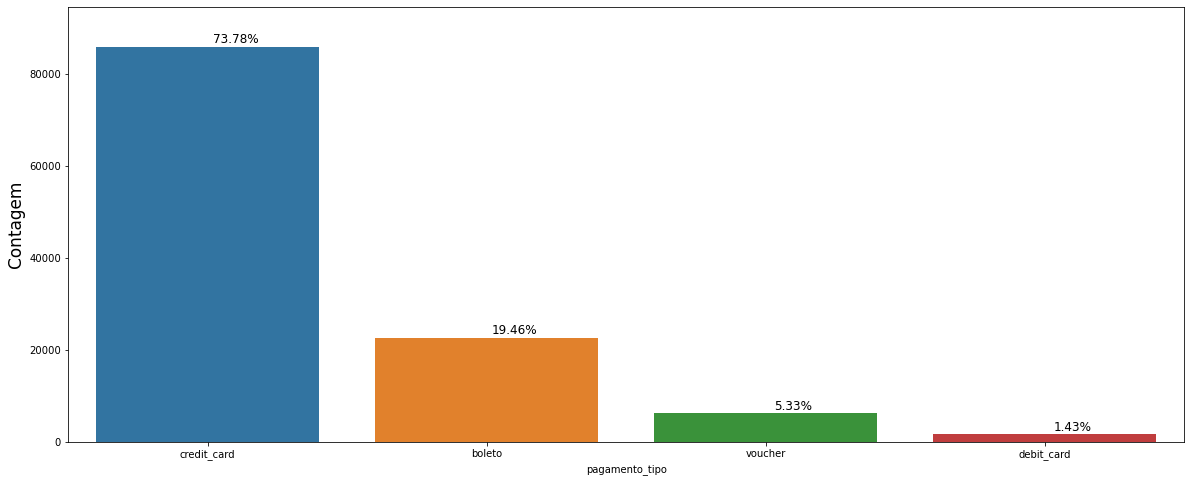

In [7]:
plot_perc('pagamento_tipo', df)
# maioria de pagamentos em cartão de crédito 
# insight: poderíamos incentivar a compra à vista com promoções

# Alguns indicadores que iremos analisar: 

> # Análise RFM

>  ### Recência (R)
> #### Há quantos dias foi a última compra desse cliente 

>  ### Frequência (F)
> #### Quantas compras esse cliente já fez na sua empresa, desde que se cadastrou?

>  ### Monetariedade (M)
> #### Quanto esse cliente já gastou em dinheiro na sua empresa?

## Usando o pacote datetime

In [8]:
df_olist = df[['id_unico_cliente','id_cliente','horario_pedido','item_id','preco']]
df_olist.head() ## novos dados. selecionamos apenas algumas variáveis.


,id_unico_cliente,id_cliente,horario_pedido,item_id,preco
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99


In [9]:
df_compra = df.groupby(df['id_unico_cliente']).horario_pedido.max().reset_index()
#df_teste = df.groupby(df['id_unico_cliente']).horario_pedido.max().reset_index()
#df_teste.info()

In [10]:
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra'] #renomeando as colunas
df_compra.head() 

,id_unico_cliente,DataMaxCompra
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [11]:
df_compra['DataMaxCompra'] = pd.to_datetime(df_compra['DataMaxCompra'])
df_compra.head() # aplicando a função to_datetime do pandas, converte um objeto em objeto datetime


,id_unico_cliente,DataMaxCompra
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


## Calculando a Recência tomando como referência o último dia em que foi cadastrada uma nova compra na base de dados

In [12]:
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days
# pego como referência a compra mais recente no banco de dados para contar há quantos dias
# foi a última compra de cada cliente. 

df_compra.head()

,id_unico_cliente,DataMaxCompra,Recencia
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


In [13]:
df_compra.index[df_compra['Recencia'] == 0]

Int64Index([93757], dtype='int64')

In [14]:
df_compra.iloc[93757]

id_unico_cliente    ff22e30958c13ffe219db7d711e8f564
DataMaxCompra                    2018-09-03 09:06:57
Recencia                                           0
Name: 93757, dtype: object

In [15]:
df_compra['DataMaxCompra'].max()

Timestamp('2018-09-03 09:06:57')

### -------------------------------------------------------------------------------------------------------------------------

## Unindo o df_compra com o df_olist




In [16]:
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente', 'Recencia']], on = 'id_unico_cliente')
df_usuario.sample(10)
# vamos usar somente as variáveis 'id_unico_cliente' e 'Recencia' do df_compra. 

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
101036,d07fdfa2b78ab36b0f339706aa4f5a09,05f830d6d4afd135824b04ce45d20f00,2017-12-05 21:26:28,1,22.80,271
51107,a88ddb886ec892589db987f01cf9b747,1287bb4d651bd96d3b090a92997ae7ea,2017-03-20 14:44:16,1,90.50,531
99800,f9ddad97b1a41864dbf8b1dc6bcc028f,cd1b76220f1ef8834081af5831663e44,2017-10-12 08:41:46,1,59.90,326
32248,9cf6dec2e760c65ea7cb496593d3af57,27252cd6ebbc6360b155eea3fa40ee70,2017-05-18 18:10:03,1,48.90,472
96684,b3c9b7344ef8e0ec9560dfe3cccd0b5e,7082edd9f78fb9d07560b4f9d65f7095,2017-10-03 21:27:23,1,359.00,334
16816,7575dad0caa94d97f8e293ad8f3c676f,d3ddbbd220a088a3e353cd270c184e60,2018-08-09 17:18:57,1,89.00,24
32349,baa50e17cfa4f8b6b85de04660cecd40,51099d172d85ee8e5693acfcbbd0f0a9,2017-03-30 22:38:45,1,65.90,521
60149,b2e9a05d23ea17713b5d7799f2004f8e,0b42763d66e65a34f6e2978facaf93da,2018-07-26 14:26:07,6,15.00,36
39124,ea13a9158374ce67973f439aa9fa5a6f,5c51bb8cca78612d40a130b05279cd5d,2017-05-25 17:46:31,1,259.99,465
108634,b9c898145cb368ed02e3c302eb42ab7d,2d0eb4225831ecebc89c64829e35c31d,2017-11-15 14:16:19,1,65.99,291


## Vamos CLUSTERIZAR os dados a partir da RECÊNCIA,
### Conceitos de Elbow Method

In [17]:
def calcular_wcss(data):
    wcss = [] #criando um vetor vazio
    for k in range(1,10): #  10 = quantidade de clusters. É um chute e pode ser alterado. 
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X=data)
        data['Clusters']=kmeans.labels_ #labels_ dá o cluster ao qual aquele id_cliente pertence.
        wcss.append(kmeans.inertia_) #inertia_ é uma função do kmeans que retorna a soma dos quadrados. 
                                  # Faremos para n_clusters = 2,3,4...10 
    return wcss

In [18]:
from sklearn.cluster import KMeans

In [19]:
df_recencia = df_usuario[['Recencia']] # criando um DF apenas com os valores de Recencia.
df_recencia.head()

,Recencia
0,474
1,298
2,298
3,483
4,211


In [20]:
# Calculando as inércias para n clusters
soma_quadrados = calcular_wcss(df_recencia)
soma_quadrados

/tmp/ipykernel_146463/288437329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Clusters']=kmeans.labels_ #labels_ dá o cluster ao qual aquele id_cliente pertence.
/tmp/ipykernel_146463/288437329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Clusters']=kmeans.labels_ #labels_ dá o cluster ao qual aquele id_cliente pertence.
/tmp/ipykernel_146463/288437329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

[2733029504.942882,
 807902990.2845452,
 362053130.0620208,
 213835574.30462363,
 135886903.30292425,
 96312289.57688175,
 69805799.92426102,
 55761382.70317302,
 44173417.65566618]

> ## Forma da curva de inércia. 3 ou 4 parecem números adequados para o número de clusters

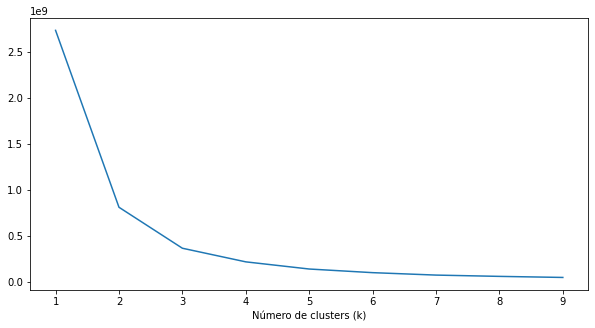

In [21]:
x = np.arange(1,10)
plt.figure(figsize=(10,5))
plt.plot(x,soma_quadrados)
plt.xlabel('Número de clusters (k)')
plt.show()  

In [22]:
# Codificando a função. Nessa função os índices 0 e 1 representam o primeiro e o último n_cluster, respectivamente.
# e os elementos x e y que aparecem sem índice são a posição (x,y) do n_cluster com o qual o cálculo está sendo feito
# Esse cálculo é feito para todos os n_clusters na curva do cotovelo e toma-se como ótimo aquele que tem
# a maior distância até a reta traçada. 

In [23]:
import math 

def numero_max_clusters(wcss):
    x1, y1 = 2, wcss[1] # Po = começando de 2 clusters. Coloquei a inércia de n=2, wcss[1].
    x2, y2 = 9, wcss[len(wcss)-1] #último ponto. O último índice é o len(objeto)-1, pois a contagem começa em 0.
    
    distancia = []
    for i in range(1,len(wcss)): # range vai de 0 a 'último' - 1:  range (5) = 0,1,2,3,4
        x0 = i+1
        y0 = wcss[i] # o len(wcss) = 9, mas só vai até i = 8, um antes. 
        numerador = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancia.append(numerador/denominador)
    
    return distancia.index(max(distancia)) +2, len(distancia) 

## Número ótimo de clusters = 4

In [24]:
numero_max_clusters(soma_quadrados)

(4, 8)

In [25]:
kmeans = KMeans(n_clusters = 4)

In [26]:
df_usuario['RecenciaCluster'] = kmeans.fit_predict(df_recencia)
df_usuario.sample(5)

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
53818,a0dc0910971f4c957ca0d19416566c47,4bb0b800e2bafd5b1df51ea1e45e780b,2017-03-24 10:53:14,1,189.9,527,1
59283,d557b0de499fba598492f6c77b8b56ab,1737ebe20c3faf8da6877df534f55e0a,2018-01-03 17:17:52,1,59.9,242,0
77528,54de682f0fdd9e588983277f98bdd15d,09aac084452bfe2880d35d02858aa98e,2017-06-22 22:22:55,1,95.0,437,1
91363,56cc3b271716ef0cbfe021bee7a6ddca,fb694f1a733efde390f6d93e122b702f,2018-06-07 15:59:08,1,119.9,87,2
45226,fc29da50ccc5a3cbdadf475432a8caa7,ede1d05d53f82a21a82e22a89aaf01c3,2017-12-10 19:31:51,1,124.9,266,3


## Calculando o valor médio das recências por grupo.


In [27]:
agrupado_por_cluster = df_usuario.groupby('RecenciaCluster')['Recencia'].mean().reset_index()
agrupado_por_cluster.head() 

,RecenciaCluster,Recencia
0,0,187.911204
1,1,490.622269
2,2,66.790878
3,3,320.233294


In [28]:
agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by='Recencia',ascending=False).reset_index(drop=True)
agrupado_por_cluster_ordenado.head() # ordenando em ordem descrescente

,RecenciaCluster,Recencia
0,1,490.622269
1,3,320.233294
2,0,187.911204
3,2,66.790878


## Clientes que estão há mais tempo sem comprar formam o grupo 0.


In [29]:
agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
agrupado_por_cluster_ordenado # associando os índices à Recência ordenada. 


,RecenciaCluster,Recencia,index
0,1,490.622269,0
1,3,320.233294,1
2,0,187.911204,2
3,2,66.790878,3


In [30]:
juntando_cluster = pd.merge(df_usuario, agrupado_por_cluster_ordenado[['RecenciaCluster', 'index']], 
                           on = 'RecenciaCluster')
juntando_cluster.head() # juntando os DF's com os grupos formados. 

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,1,0


## Clientes mais recentes ganham maior pontuação (3). 

In [31]:
removendo_dados = juntando_cluster.drop(['RecenciaCluster'],axis=1)
removendo_dados.head() # removendo a coluna RecenciaCluster, pois não é mais necessária. Agora usaremos os grupos


,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [32]:
df_final = removendo_dados.rename(columns = {'index': 'RecenciaCluster'}) #usamos o nome RecenciaCluster de novo.
df_final.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


## Construindo uma função para refazer esses passos para Frequência e Receita

In [33]:
def ordenador_cluster(cluster_nome, target_nome, df):
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                 ascending=True).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df, agrupado_por_cluster_ordenado[[cluster_nome, 'index']], 
                           on = cluster_nome)

    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns = {'index': cluster_nome}) 
    
    return df_final


# trocamos 'RecenciaCluster' por cluster_name, "Recencia" por target_name e "df_usario" por df.

In [34]:
# testando em df_usuario. 
df_usuario = ordenador_cluster('RecenciaCluster', 'Recencia', df_usuario)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,3
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,3
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,3


In [35]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe().reset_index()

,RecenciaCluster,count,mean,std,min,25%,50%,75%,max
0,0,31790.0,66.790878,36.009443,0.0,33.0,67.0,100.0,127.0
1,1,33639.0,187.911204,35.134736,128.0,158.0,187.0,218.0,254.0
2,2,30828.0,320.233294,43.971639,255.0,281.0,314.0,357.0,405.0
3,3,20324.0,490.622269,59.293154,406.0,444.0,481.0,533.0,728.0


## Calculando a frequência de compra de cada cliente
 

In [36]:
df_frequencia = df.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente','Frequencia']

In [37]:
## adicionando ao df_usuario

df_usuario = pd.merge(df_usuario,df_frequencia, on = 'id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,3,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,3,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,3,1


## Agrupando os dados pela Frequência

In [38]:
df_frequencia = df_usuario[['Frequencia']]

In [39]:
# aplicando k-means à Frequencia
kmeans = KMeans(n_clusters = 4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)


In [40]:
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,619.0,22.844911,6.267127,15.0,19.0,22.0,24.0,38.0
2,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0
3,9317.0,5.744875,2.312449,4.0,4.0,5.0,6.0,14.0


In [41]:
# chamando a função ordenador_cluster para organizar os índices
#e atribuir número maior aos clientes mais recorrentes.

df_usuario = ordenador_cluster('FrequenciaCluster', 'Frequencia', df_usuario)


In [42]:
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,9317.0,5.744875,2.312449,4.0,4.0,5.0,6.0,14.0
2,619.0,22.844911,6.267127,15.0,19.0,22.0,24.0,38.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


>  # Agrupando os dados pela Receita

In [43]:
df_receita = df.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()


In [44]:
df_receita.columns = ['id_unico_cliente', 'Receita']


In [45]:
df_usuario = pd.merge(df_usuario, df_receita, on = 'id_unico_cliente')


In [46]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3,1,0,146.87
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3,1,0,140.61
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,3,1,0,142.05
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,3,1,0,155.70
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,3,1,0,148.33


### Fazendo o agrupamento

In [47]:
kmeans = KMeans(n_clusters = 4)
df_pagamento = df_usuario[['Receita']]

In [48]:
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)

In [49]:
# ordenando 

df_usuario = ordenador_cluster('ReceitaCluster', 'Receita', df_usuario)


In [50]:
df_usuario.groupby('ReceitaCluster')['Receita'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114763.0,258.095126,364.892800,9.59,69.90,132.57,269.10,2950.16
1,1619.0,5650.053385,2881.999747,2951.83,3557.12,4491.44,6914.63,16313.60
2,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


 >  # Construindo um score para os clientes a partir das pontuações em Recência, Frequência e Receita 

In [51]:
import sys  ## para remover os warnings 
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [52]:
df_final = df_usuario[['id_unico_cliente','Recencia','RecenciaCluster',
                       'Frequencia','FrequenciaCluster','Receita','ReceitaCluster']]
df_final.tail()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
116576,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3
116577,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3
116578,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3
116579,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3
116580,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3


In [53]:
df_final['Pontuacao'] = df_usuario['RecenciaCluster'] + df_usuario['FrequenciaCluster'] + \
                         df_usuario['ReceitaCluster'] 

# A maior pontuação que um cliente possui é 6

In [54]:
df_final['Pontuacao'].max() .
# isso pode ser passado para o marketing, por exemplo.

6

## Separando os clientes em segmentos: Inativo, Business, Master e Premium, conforme a pontuação

In [60]:
df_final['Segmento'] = 'Inativo' # inicialmente todos estão inativos.

In [61]:
df_final.loc[df_final['Pontuacao']>=1,'Segmento'] = 'Business'
df_final.loc[df_final['Pontuacao']>=3,'Segmento'] = 'Master'
df_final.loc[df_final['Pontuacao']>=5,'Segmento'] = 'Premium'

In [62]:
df_final.tail()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao,Segmento
116576,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3,6,Premium
116577,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3,6,Premium
116578,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3,6,Premium
116579,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3,6,Premium
116580,0a0a92112bd4c708ca5fde585afaa872,338,2,8,1,109312.64,3,6,Premium


In [63]:
df_final.to_csv('RFM.csv')

# Análises visuais

## Definiremos uma função para ver como as variáveis RFM se relacionam entre si.

In [64]:
def plot_segmento(x,y,data):
    sns.set(palette='muted',color_codes=True,style='whitegrid') # definindo a paleta de cores
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=x,y=y,hue='Segmento',data=data,size='Segmento',
                    sizes=(50,150),size_order=['Premium','Master','Business','Inativo'])
    plt.show()

## Plot Recência x Frequência'

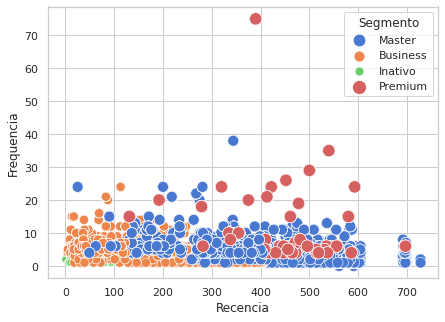

In [65]:
plot_segmento('Recencia', 'Frequencia', df_final)

## Plot Recência x Receita

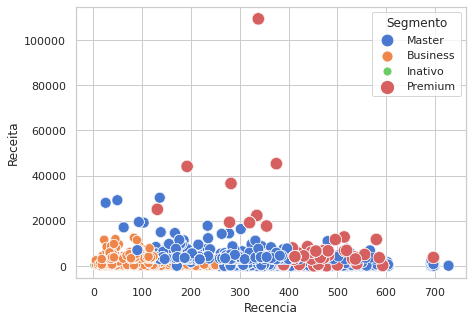

In [66]:
plot_segmento('Recencia', 'Receita', df_final)

## Plot Frequência x Receita

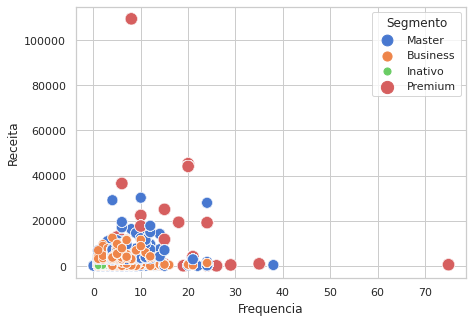

In [67]:
plot_segmento('Frequencia', 'Receita', df_final)

## Plot Segmento 

<AxesSubplot:xlabel='Segmento', ylabel='count'>

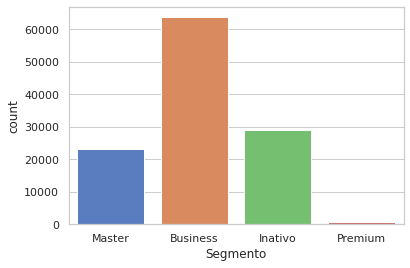

In [69]:
sns.countplot(df_final['Segmento']) 